# Python Imports

In [2]:
import io
import os
import sys
from time import time
import numpy as np
from PIL import Image
import pandas as pd
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Control Constants

In [3]:

WIDTH = 500
HEIGHT = 500
MARGIN = 0
RADIUS = 5

WHITE ='#FFFFFF'
RED = '#FF0000'
DARK_RED = '#660000'
GREEN = '#00FF00'
BLUE = '#0000FF'
BLACK =  '#000000'
BACKGROUND = 'rgba(50,205,50)'


In [10]:
LAYOUT = go.Layout(
    
    autosize=False,
    width=WIDTH+MARGIN,
    height=HEIGHT+MARGIN,
    plot_bgcolor=GREEN,
    paper_bgcolor=WHITE,
    margin=dict(l=MARGIN//2, r=MARGIN//2, t=MARGIN//2, b=MARGIN//2)
)
MARKER_SETTINGS = dict(size=RADIUS, color=RED, line=dict(width=2, color=RED))
print(LAYOUT)
print("Marker Settings: {}".format(MARKER_SETTINGS))

Layout({
    'autosize': False,
    'height': 500,
    'margin': {'b': 0, 'l': 0, 'r': 0, 't': 0},
    'paper_bgcolor': '#FFFFFF',
    'plot_bgcolor': '#00FF00',
    'width': 500
})
Marker Settings: {'size': 5, 'color': '#FF0000', 'line': {'width': 2, 'color': '#FF0000'}}


In [35]:
def plotly_fig2array(fig):
    fig_bytes = fig.to_image(format='png')
    buffer = io.BytesIO(fig_bytes)
    img = Image.open(buffer)
    arr = np.asarray(img)
    return arr

def traceof(x, y):
    return go.Scatter(x=x, y=y, mode='markers', marker=MARKER_SETTINGS)

def lineof(x, y, name=""):
    return go.Scatter(x=x, y=y, mode='lines', name=name)

def figure(x, y):
    fig = go.Figure(layout=LAYOUT)
    fig.add_trace(traceof(x, y))
    return fig

def ImageOf(x, y, pixels_only=True):
    if pixels_only:
        return plotly_fig2array(figure(x, y))
    else:  
        raw_img_data = plotly_fig2array(figure(x, y))
        return raw_img_data, Image.fromarray(raw_img_data)

# Question One

Does the degree of correlation effect the number of samples needed to effectively display a linear trend in the data?


### Uniform Sampling Case

$$
p(x) = \frac{1}{b-a}
$$

### Normal Distribution

$$
p(x) = N(u, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{\frac{(x - u)^2}{\sigma^2}}
$$

In [7]:
n = 100000
a, b = 0, 1
midpoint = (b - a) / 2

x_uniform, x_normal = np.random.uniform(a, b, n), np.random.normal(size=n)
y_uniform, y_normal = np.random.uniform(a, b, n), np.random.normal(size=n)

In [11]:
trace_xu_yu = go.Scatter(x=x_uniform, y=y_uniform, mode='markers', marker=MARKER_SETTINGS)
trace_xu_yn = go.Scatter(x=x_uniform, y=y_normal,  mode='markers', marker=MARKER_SETTINGS)
trace_xn_yu = go.Scatter(x=x_normal,  y=x_uniform,  mode='markers', marker=MARKER_SETTINGS)
trace_xn_yn = go.Scatter(x=x_normal,  y=y_normal,   mode='markers', marker=MARKER_SETTINGS)

R =  -0.001839395919088705
Output Shape: (500, 500, 4)


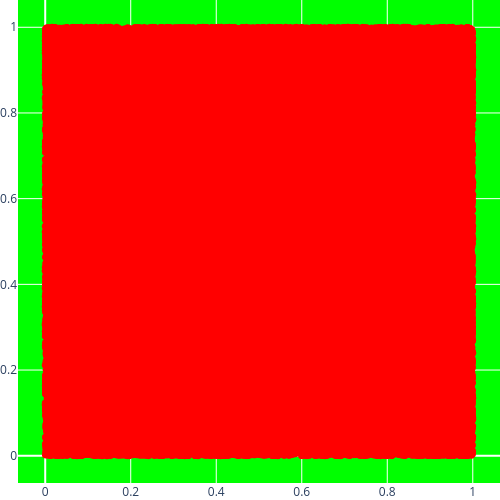

In [12]:
fig1 = go.Figure(layout=LAYOUT)
fig1.add_trace(trace_xu_yu)
xu_yu_img = plotly_fig2array(fig1)
print("R = ", np.corrcoef(x=x_uniform, y=y_uniform)[0, 1])
print("Output Shape: {}".format(xu_yu_img.shape))
Image.fromarray(xu_yu_img)

R =  -0.0011858976685657201
Output Shape: (500, 500, 4)


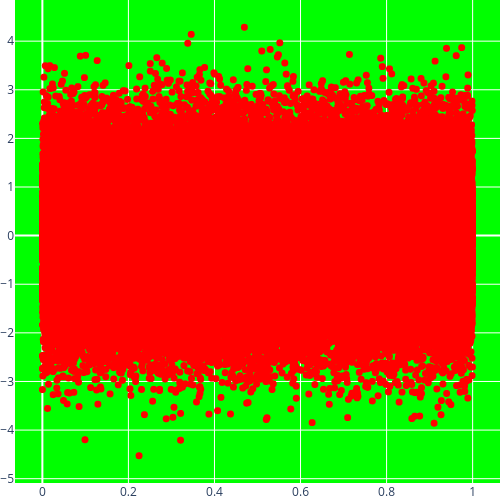

In [13]:
fig2 = go.Figure(layout=LAYOUT)
fig2.add_trace(trace_xu_yn)
xu_yn_img = plotly_fig2array(fig2)
print("R = ", np.corrcoef(x=x_uniform, y=y_normal)[0, 1])
print("Output Shape: {}".format(xu_yn_img.shape))
Image.fromarray(xu_yn_img)

R =  0.0059125346472255706
Output Shape:  (500, 500, 4)


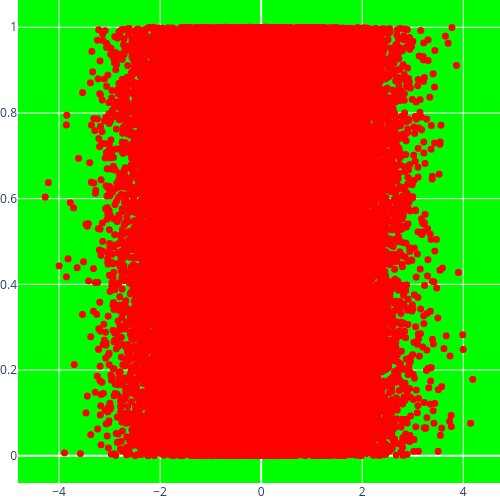

In [14]:
fig3 = go.Figure(layout=LAYOUT)
fig3.add_trace(trace_xn_yu)
xn_yu_img = plotly_fig2array(fig3)
print("R = ", np.corrcoef(x=x_normal, y=y_uniform)[0, 1])
print("Output Shape: ", xn_yu_img.shape)
Image.fromarray(xn_yu_img)

R =  0.010624768156196958
Output Shape:  (500, 500, 4)


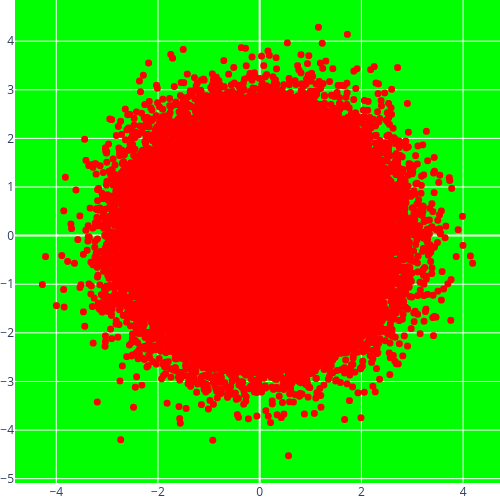

In [15]:
fig4 = go.Figure(layout=LAYOUT)
fig4.add_trace(trace_xn_yn)
xn_yn_img = plotly_fig2array(fig4)
print("R = ", np.corrcoef(x=x_normal, y=y_normal)[0, 1])
print("Output Shape: ", xn_yn_img.shape)
Image.fromarray(xn_yn_img)

Things to note. The correlatation between two vairables is the their shared percentage of shared determinants. For instance, smoking and lung cancer have a shared determinant of carcinogens which explains their observed correlation. So what the above plots are demonstrating is that independently operating distributions yield low correlation values.


A distribution or relation can take multiple arbitrary shapes. Note that a normal distribution is less sparse than a uniform distribution, it therefore consumes less 'space' then a uniform distribution.
For any dataset, there can be multiple distributions present. For a generic online sampler, we have no prior on what distribution will be observed. This is partly why uniform random sampling is so prevalent.

Let's take the persepctive of a data analyst looking to quick visaulize possible trends in the data. Assume the dataset is well over 1M data points so visualizaing all of them is impractical for interactive, exploratory uses.

1) What is the minimum number of samples needed to confidently capture a trend or conclude there is no trend in the data?

2) What is the number of samples needed in which updates to the plot yield no perceptable difference in final image?

Right now you have a generic Buffon Coin sampler which uses the parameters of the plot to specify an upper bound on the number of samples needed to display on a plot before overplotting occurs.

3) Can you this sampling methodolgy capture enough data to have a correlation or not?

# Image Metrics

In [16]:
def norm(x: np.array, y: np.array, p=2):
    if x.shape != y.shape:
        raise ValueError("Mismatch Input Element Shape. X-Shape: {} != Y-Shape: {}", x.shape, y.shape)
    if p != 1 and p != 2:
        raise ValueError("Only Support L1 and L2 Norms. Input p = {}", p)
    return np.sqrt((np.sum(np.abs(x - y)**p)))

def epsilon(data):
    return np.linalg.norm(np.max(data, axis=0) - np.min(data, axis=0)) / 100

def kappa(S, X, epsilon):
    return np.exp(-(np.linalg.norm(X[:, None, :] - S[None, :, :], axis=-1)**2) / epsilon)

def vas_loss_fn(S, X, epsilon):
    return np.sum(1 / np.sum(kappa(X=X, S=S, epsilon=epsilon), axis=1))

def log_loss_ratio(S, X):
    return np.log10(np.divide(vas_loss_fn(X, S), vas_loss_fn(X, X)))

class Normal:

    def __init__(self, p=2):
        self.p = p

    def __call__(self, x: np.array, y: np.array):
        return norm(x=x, y=y, p=self.p)

    def __str__(self):
        if self.p == 2:
            return "Mean Squared Error"
        else:
            return "Manhatten"


class SSIM:

    def __init__(self, win_size=7, channel_axis=2):
        self.win_size = win_size
        self.channel_axis = channel_axis

    def __call__(self, x: np.array, y: np.array):
        return ssim(x, y, win_size=self.win_size, channel_axis=self.channel_axis)

    def __str__(self):
        return "SSIM"

class VAS:

    def __init__(self, full_data):
        self.epsilon = epsilon(full_data)

    def __call__(self, S: np.array, X: np.array):
        return vas_loss_fn(S=S, X=X, epsilon=self.epsilon)

    def __str__(self):
        return "VAS"

# Builder Functions

In [19]:
class Sample:
    def __init__(self, data, img):
        self.data = data
        self.img = img
        self.correlation = np.corrcoef(x=data[:, 0], y=data[:, 1])[0, 1]
    
    def __str__(self):
        return f"Sample {self.data.shape}. K = {len(self.data)}"

    def __len__(self):
        return len(self.data)

    def r(self):
        return self.correlation
    
    def x(self):
        return self.data[:, 0]

    def y(self):
        return self.data[:, 1]

    def image(self):
        return Image.fromarray(self.img)

def build_sample_space(size):
    if size < int(1e4):
        raise ValueError("Expecting Sample Sizes Larger Than 10000. Input Size: {}".format(size))
    min, low, mid, high, max = (np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0]) * size).astype(int)
    return np.concatenate((
        np.linspace(start=min,  stop=low,  num=10)[:-1],
        np.linspace(start=low,  stop=mid,  num=10)[:-1],
        np.linspace(start=mid,  stop=high, num=10)[:-1],
        np.linspace(start=high, stop=max,  num=10)
    )).astype(int)

def build_samples(full_data, sample_rates):
    samples = dict()
    for K in sample_rates:
        print(f'Building Sample {K} of {len(full_data)}')
        sample_data = full_data[np.random.permutation(len(full_data))[:K], :]
        sample_img = ImageOf(x=sample_data[:, 0], y=sample_data[:, 1], pixels_only=True)
        sample_instance = Sample(data=sample_data, img=sample_img)
        samples[len(sample_instance)] = sample_instance
    return samples

def distance(a, b, metric):
    if str(metric) == 'VAS':
        return metric(a.data, b.data)
    else:
        return metric(a.img, b.img)

# Evaluation Functions

In [17]:
def evaluate(samples, target, metric, verbose=False):
    distances = {}
    for sample in samples.values():

        if verbose:
            print(f'Measuring {metric} for {sample} with respect to {target}')

        if str(metric) == 'VAS':
            if len(sample) <= 10000:
                distances[len(sample)] = metric(sample.data, target.data)
            else:
                break
        else:
            distances[len(sample)] = metric(sample.img, target.img)
    return distances 

# Experiment 1

Lets start simple. Assume there is a linear trend $y=x$. The variable $x$ is normally distributed with $y$ normally distributed from it.


## Experiment 1 Data Preparation And Result Generation

In [20]:
N = int(1e5)
x = np.random.normal(size=N)
y = x + np.random.normal(size=N)
x_y = np.concatenate((x[None, :].T, y[None, :].T), axis=1)
sample_space = build_sample_space(N)

geometric_sample_space = np.geomspace(
    start=int(0.01 * N),
    stop=N,
    num=10,
    dtype=int
)

print("")
print("Full Data Shape: ", x_y.shape)
print("")
print('Sample Space:\n', sample_space)
print()
print('Geometric Sample Space:\n', geometric_sample_space)


Full Data Shape:  (100000, 2)

Sample Space:
 [    10     20     30     40     50     60     70     80     90    100
    200    300    400    500    600    700    800    900   1000   2000
   3000   4000   5000   6000   7000   8000   9000  10000  20000  30000
  40000  50000  60000  70000  80000  90000 100000]

Geometric Sample Space:
 [  1000   1668   2782   4641   7742  12915  21544  35938  59948 100000]


In [21]:
samples = build_samples(full_data=x_y, sample_rates=sample_space)

Building Sample 10 of 100000
Building Sample 20 of 100000
Building Sample 30 of 100000
Building Sample 40 of 100000
Building Sample 50 of 100000
Building Sample 60 of 100000
Building Sample 70 of 100000
Building Sample 80 of 100000
Building Sample 90 of 100000
Building Sample 100 of 100000
Building Sample 200 of 100000
Building Sample 300 of 100000
Building Sample 400 of 100000
Building Sample 500 of 100000
Building Sample 600 of 100000
Building Sample 700 of 100000
Building Sample 800 of 100000
Building Sample 900 of 100000
Building Sample 1000 of 100000
Building Sample 2000 of 100000
Building Sample 3000 of 100000
Building Sample 4000 of 100000
Building Sample 5000 of 100000
Building Sample 6000 of 100000
Building Sample 7000 of 100000
Building Sample 8000 of 100000
Building Sample 9000 of 100000
Building Sample 10000 of 100000
Building Sample 20000 of 100000
Building Sample 30000 of 100000
Building Sample 40000 of 100000
Building Sample 50000 of 100000
Building Sample 60000 of 10000

In [22]:
print(samples[N])
ground_truth = samples[N]

Sample (100000, 2). K = 100000


In [23]:
ssim_metric = SSIM()
rmse, manhat = Normal(p=2), Normal(p=1)
vas = VAS(full_data=x_y)

In [24]:
r_scores = np.array([s.r() for s in samples.values()])
manhat_distances  = evaluate(samples,  ground_truth, manhat)
rmse_distances    = evaluate(samples,  ground_truth, rmse)
ssim_distances    = evaluate(samples , ground_truth, ssim_metric)

In [25]:
vas_distances = evaluate(samples, ground_truth, vas, verbose=True)

Measuring VAS for Sample (10, 2). K = 10 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (20, 2). K = 20 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (30, 2). K = 30 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (40, 2). K = 40 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (50, 2). K = 50 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (60, 2). K = 60 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (70, 2). K = 70 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (80, 2). K = 80 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (90, 2). K = 90 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (100, 2). K = 100 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (200, 2). K = 200 with respect to Sample (100000, 2). K = 100000
Measuring VAS for Sample (30

## Experiment 1 Correlation Notes

The correlations are well bounded over near the true correlation over the entire sample space. The correlation is well bounded at 10 percent of the data.

Somewhere between a 1% and 10% of the data. Our correlation measurements converge with +/- 0.01 of the true correlation. So for trend analysis we should never go above 10% sample
spaces. We should try and derive an objective images function which mathces this expected behavior between 1 and 10 percent of the data.

In [148]:
r_line = go.Figure(lineof(x=sample_space, y=r_scores))
r_line.update_xaxes(type='log')
r_line

## Experiment 1 Notes On Distances

Structural Similarity is high accross entire sample space. Becomes volatile as outliers have more changes to be included/excluded with increasing sample sizes. This pattern persists even in low sample spaces. Note that an upward trend in structural similarity is only observed over large sample steps withing the image. 

Upon observation. SSIM is highly similar throughout. This is likely due to the background comparision so trying to implement VAS to get a metric grounded in the data might be helpful.

What we really want to generate is an ideal curve which drops quickly at the beginning and then has a low tail towards the final image.


### Manhatten

In [46]:
manhat_line = go.Figure(lineof(x=list(manhat_distances.keys()), y=list(manhat_distances.values()), name='Manhatten'), layout=go.Layout(dict(width=600, height=300, margin=dict(t=30,b=20,l=20,r=20))))
manhat_line.add_trace(lineof(x=list(rmse_distances.keys()), y=list(rmse_distances.values()), name="RMSE"))
manhat_line.update_layout(title='Euclidean Distance of Samples To Ground Truth', xaxis_title='Sample Sizes', yaxis_title='Distance (Luminance)')
#manhat_line.update_xaxes(type='log')
manhat_line

### Root Mean Square Error

In [32]:
rmse_line = go.Figure(lineof(x=list(rmse_distances.keys()), y=list(rmse_distances.values())))
rmse_line.update_xaxes(type='log')
rmse_line

### Stuctual Similarity

In [36]:
ssim_line = go.Figure(lineof(x=list(ssim_distances.keys()), y=list(ssim_distances.values())))
ssim_line.update_xaxes(type='log')
ssim_line

### VAS

In [18]:
vas_line = go.Figure(lineof(x=list(vas_distances.keys()), y=list(vas_distances.values())))
vas_line.update_yaxes(type='log')
vas_line.update_xaxes(type='log')
vas_line

## Experiment 1 Image Analysis

The Stuctural Similarity Between A Sample Size of 1 Percent is aleady similar but sparse relative to the final image. This initial test suggests the bounds of sampling should be limited between 1 and 10 Percent.

### Sample Rate 0.1%

Manhat score @ 100 / 100000 = 4952.825658147074
RMSE score @ 100 / 100000 = 2119.6815798605226
SSIM score @ 100 / 100000 = 0.6839908172599163
VAS Score @ 100 / 100000 = 3.252130965428669e+19


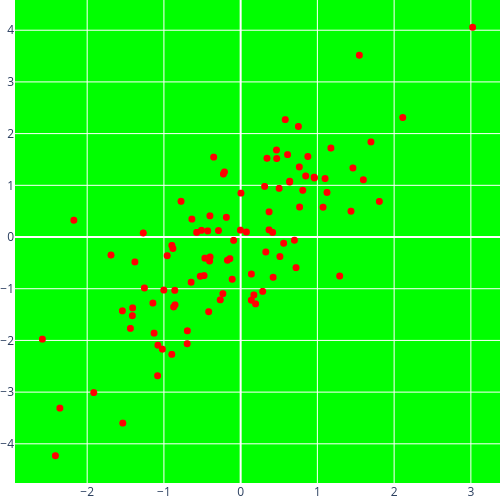

In [44]:
print("Manhat score @ {} / {} = {}".format(100, N, manhat_distances[100]))
print("RMSE score @ {} / {} = {}".format(100, N, rmse_distances[100]))
print("SSIM score @ {} / {} = {}".format(100, N, ssim_distances[100]))
print("VAS Score @ {} / {} = {}".format(100, N, vas_distances[100]))
samples[100].image()

### Sample Rate 1.0%

Manhat score @ 1000 / 100000 = 4391.271228243594
RMSE score @ 1000 / 100000 = 2286.77392848528
SSIM score @ 1000 / 100000 = 0.6846794603672555
VAS Score @ 1000 / 100000 = 3.1036328164452496e+23


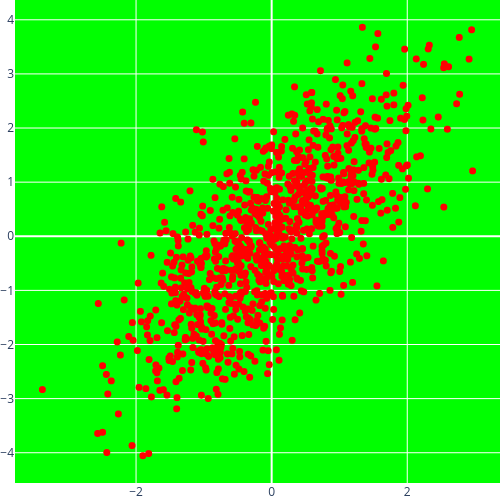

In [45]:
print("Manhat score @ {} / {} = {}".format(1000, N, manhat_distances[1000]))
print("RMSE score @ {} / {} = {}".format(1000, N, rmse_distances[1000]))
print("SSIM score @ {} / {} = {}".format(1000, N, ssim_distances[1000]))
print("VAS Score @ {} / {} = {}".format(1000, N, vas_distances[1000]))
samples[1000].image()

### Sample Rate 10%

Manhat score @ 10000 / 100000 = 3419.172268254409
RMSE score @ 10000 / 100000 = 2131.673755526394
SSIM score @ 10000 / 100000 = 0.7663875879254858
VAS Score @ 10000 / 100000 = 1103775.8667700817


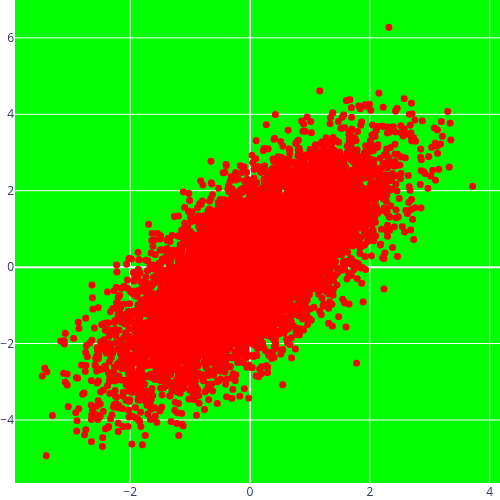

In [46]:
print("Manhat score @ {} / {} = {}".format(10000, N, manhat_distances[10000]))
print("RMSE score @ {} / {} = {}".format(10000, N, rmse_distances[10000]))
print("SSIM score @ {} / {} = {}".format(10000, N, ssim_distances[10000]))
print("VAS Score @ {} / {} = {}".format(10000, N, vas_distances[10000]))
samples[10000].image()

### Sample Rate 100%

Manhat score @ 100000 / 100000 = 0.0
RMSE score @ 100000 / 100000 = 0.0
SSIM score @ 100000 / 100000 = 1.0


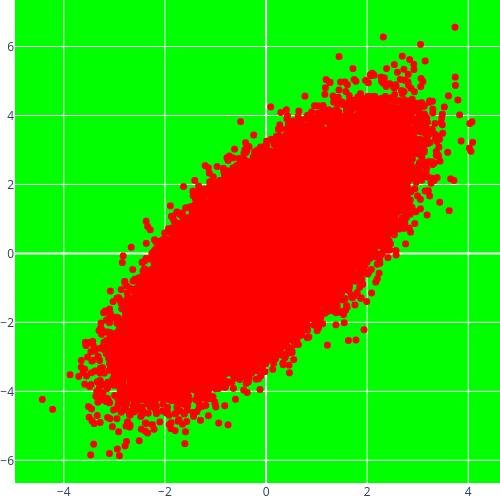

In [48]:
print("Manhat score @ {} / {} = {}".format(N, N, manhat_distances[N]))
print("RMSE score @ {} / {} = {}".format(N, N, rmse_distances[N]))
print("SSIM score @ {} / {} = {}".format(N, N, ssim_distances[N]))
samples[N].image()

## VAS Variance

Generate 50 Observations of VAS Measurements At Various Sizes. Get a normal curve around there possible values at each sample rate. This should smooth out the behaviour.

In [49]:
def observe_vas(sample_rate=0.1):
    vas_measurements = []
    for i in range(50):
        sample = x_y[np.random.permutation(len(x_y))[:int(sample_rate*len(x_y))], :]
        vas_measurements.append(vas(sample, x_y))
    vas_measurements = np.array(vas_measurements)
    return np.mean(vas_measurements), np.var(vas_measurements), np.std(vas_measurements)

### VAS Variance 0.1%

In [ ]:
u, var, std = observe_vas(sample_rate=0.001)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 2.282e+74, var = 1.355e+150, std = 1.164e+75


### VAS Variance 1%

In [ ]:
u, var, std = observe_vas(sample_rate=0.01)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 1.43e+35, var = 9.948e+71, std = 9.974e+35


### VAS Variance 10%

In [ ]:
u, var, std = observe_vas(sample_rate=0.1)
print(f"Sample Rate 0.1 Percent. u = {u:.4}, var = {var:.4}, std = {std:.4}")

Sample Rate 0.1 Percent. u = 1.331e+13, var = 1.52e+27, std = 3.899e+13


# Experiment 2

# Experiment 3

# Experiment 4

# Other

A note on this sample rate. It scales with the population size. Might be worth exploring how to update sampling rates to be smaller increments in extreeme cases.

In [ ]:
def correlations_over_samples(data, sample_rates):
    correlations = []
    for k in sample_rates:
        indices = np.random.permutation(k)
        correlation = np.corrcoef(x=data[indices, 0], y=data[indices, 1])[0, 1]
        correlations.append(correlation)
    return np.array(correlations)

In [ ]:
r_values = correlations_over_samples(data, sample_rates)

In [ ]:
line_fig = go.Figure(lineof(x=sample_rates, y=r_values))
line_fig

Ok. So now we know how the correlation is evolving over time for this simulated dataset. How does the difference in image quality change over sample rates?

Image quality is subjective. Human judgement is a HIGHLY imprecise as a measuring device. For now, use simple objective functions such as Euclidean distance to measure the differneces in images over time. It would also be helpful to have a ground truth image score as well at all times.


It would be cool if we could implement some sort of metric closely related to Visualization Aware Sampling (VAS) to meaure image quality since. VAS can imploy the property of locality and has been correlated with user studies. (Though I am always doubtful of the representativeness of the user studies in the HCI community.)


Also note, the beginning of the correlation curve is very noisy (normally distributed around the ideal correlation value). It might be worth representing this with a heat map distribution at the beginning.

Also note, it might be worth considering only the most outlying point on this correlation curve or any such curve.

#### Analysis

In [ ]:
def scores_over_samples(data, sample_rates, metric):

    target_image_data = ImageDataOf(x=data[:, 0], y=data[:, 1])

    correlations, image_diffs, images = [], [], []
    for k in sample_rates:

        print("Generating Scores For Sample Size: {} of {} ...".format(k, len(data)))

        indices = np.random.permutation(len(data))[:k]
        x_sample, y_sample = data[indices, 0], data[indices, 1]
        
        R = np.corrcoef(x=x_sample, y=y_sample)
        correlations.append(R[0, 1])

        sample_image_data = ImageDataOf(x=x_sample, y=y_sample)
        image_diffs.append(metric(sample_image_data, target_image_data))

        images.append(Image.fromarray(sample_image_data))


    return np.array(correlations), np.array(image_diffs), images

In [ ]:
op = SSIM()
reduced_sample_rates = [100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, len(data)]
r_scores, img_scores, scatter_plot_images = scores_over_samples(data, sample_rates=reduced_sample_rates, metric=op)

In [ ]:
print("Correlations: \n", r_scores)
print("Distance Scores: \n", img_scores)

In [ ]:
r_line = go.Figure(lineof(x=reduced_sample_rates, y=r_scores))
distance_line = go.Figure(lineof(x=reduced_sample_rates, y=img_scores))

In [ ]:
r_line

In [ ]:
distance_line

In [ ]:
print("Number Of Scatter Plot Images: ", len(scatter_plot_images))
scatter_plot_image_index = 8
scatter_plot_images[scatter_plot_image_index]

In [ ]:
ground_truth = np.array(scatter_plot_images[len(scatter_plot_images)-1])
samples = [np.array(scatter_plot_images[i]) for i in range(len(scatter_plot_images))]

print("Ground Truth Dimensions: ", ground_truth.shape)
for sample in samples:
    mse, similarity = (mean_squared_error(sample, ground_truth), ssim(sample, ground_truth, win_size=7, channel_axis=2))
    print("MSE = {}, SSIM = {}".format(mse, similarity))

#### Thoughts

How much would the score improve if you catured the outliers first for the above linear trend? This should at least get the scales right, I think.... :)

What does it mean to be an outlier? (MacroBase and other literature might have relavent insights here.) In this case, we could state that the points farthest from the center our outliers.
This kind of leads to the question of how to embed distance data into an arbitrary dataset. How do we project tabular data onto the 2D plane? Can that meta data be incorporated into an online data stream?
Instead of caputring outliers, maybe we should omit them?

For now, lets use our knowledge about this graph and cheat. We will test including the 50 most extreeme (farthest distance from the center and see how that affects the distance scores) and
exlude them and see how it effects the Euclidean distance bewteen the images. Including outliers at the expense of more representative data may create an unacceptable shift in correlation.

Even if you do include the outliers as priorities, does that help or hurt the analyst in the end? Remember, they are not really (should not be) interested in the absolute image quality. They
simply need a reliable correlation which safices for exploratory analysis.

Can we generate a distance metric on images that is correlated with the observed correlation in the graph?

##### Capture 50 Outliers

In [ ]:
def select_outliers(data, k=50):
    return data[np.argsort(np.linalg.norm(data, axis=1))[-k:], :]

In [ ]:
def scores_over_samples_outliers(data, sample_rates, metric):

    target_image_data = ImageDataOf(x=data[:, 0], y=data[:, 1])

    correlations, image_diffs, images = [], [], []
    outlier_indices = np.argsort(np.linalg.norm(data, axis=1))[-50:]
    outliers, inliers = np.take(data, outlier_indices, axis=0), np.delete(data, outlier_indices, axis=0)

    print(outliers.shape)
    print(inliers.shape)

    for k in sample_rates:

        print("Generating Scores For Sample Size: {} of {} ...".format(k, len(data)))

        indices = np.random.permutation(len(inliers))[:k]
        x_sample = np.concatenate((outliers[:, 0], inliers[indices, 0]))
        y_sample = np.concatenate((outliers[:, 1], inliers[indices, 1]))
        
        
        R = np.corrcoef(x=x_sample, y=y_sample)
        correlations.append(R[0, 1])

        sample_image_data = ImageDataOf(x=x_sample, y=y_sample)
        image_diffs.append(metric(sample_image_data, target_image_data))

        images.append(Image.fromarray(sample_image_data))


    return np.array(correlations), np.array(image_diffs), images

In [ ]:
norm_op = Normal(p=2)
reduced_sample_rates = [100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, len(data)]
r_scores_outliers, img_scores_outliers, scatter_plot_image_outliers = scores_over_samples_outliers(data, sample_rates=reduced_sample_rates, metric=norm)

In [ ]:
print("Correlations: \n", r_scores_outliers)
print("Distance Scores: \n", img_scores_outliers)

In [ ]:
r_line_outliers = go.Figure(lineof(x=reduced_sample_rates, y=r_scores))
distance_line_outliers = go.Figure(lineof(x=reduced_sample_rates, y=img_scores))

In [ ]:
r_line_outliers

In [ ]:
distance_line_outliers

In [ ]:
print("Number of Scatter Plot Outlier Images: ", len(scatter_plot_image_outliers))
selected_scatter_outlier_index = 0
scatter_plot_image_outliers[selected_scatter_outlier_index]

Lets observe the degradation in $r$ , correlation, as the variance in $y$ increases. For reference, here is the correlation formula. Remember, correlation measure the shared determinant between 2 variables. As the variance in $y$ increases, their are less predicitve factors encoded in $x$. In otherwords, based on our knowledge of $x$ are objective ignorance about $y$ increases if $y$ is more volatile around $x$. If you ground this in the case of father's height prediciting child height, this is stating that the child's height is increasing being influeced by other factors such as mother's height, enviroment, childhood diet, etc... 

In [ ]:
inputs = np.random.normal(size=10000)
dep_outputs = inputs + np.random.normal(scale = 10, size=10000)
ind_outputs = np.random.normal(size=10000)

R_dep = np.corrcoef(inputs, dep_outputs)
R_ind = np.corrcoef(inputs, ind_outputs)
print("R Dependent = ", R_dep[0][1])
print("R Independent = ", R_ind[0][1])


img_test_dep, img_test_ind = ImageOf(inputs, dep_outputs), ImageOf(inputs, ind_outputs)
img_test_dep_data, img_test_ind_data = ImageDataOf(inputs, dep_outputs), ImageDataOf(inputs, ind_outputs)

print("Image Difference B/W Independent and Dependence: ", norm(img_test_dep_data, img_test_ind_data))

In [ ]:
img_test_dep

In [ ]:
img_test_ind

# VAS Visaulization Aware Sampling

The goal vector of the week was to implement a visualization objective function which was correlatated with user success. Use that objective function to evaluate where optimal samples reside when sampling.

This loss function as advertised by the authors maximized the visual fidelity of the scatter plot. Existing sampling approaches focus on minimizing the error of aggregate queries to a back-end server.

Specific Tasks Under Consideration...

1) Regression
2) Density Estimation
3) Clustering


Observations...

1) Visaulization Quality loss occurs since $S$ doesn not include all of $D$.
2) The loss at $x$ is reduced as the samples include points near $x$. 
3) If $D$ has projected datapoint @ $x$, then only a few $s \in S$ need to cover it. Diminishing marginal utility afterwards.

$$
\text{point-loss}(x) = \frac{1}{\sum_{s_i \in S} \kappa(x, s_i)}
$$

$$
\kappa(x, s_i) = \exp{\frac{-\| x - s_i \|^2}{\epsilon^2}}
$$ 

$$
Loss(S) = \int \text{point-loss}(x) \, dx = \int  \frac{1}{\sum_{s_i \in S} \kappa(x, s_i)} \, dx \approx 
$$


Full dataset $D$ of $N$ tuples $D = \{t_1, t_2, ... t_N\}$ where each tuple encodes the coordinate associated at the point displayed. So how do we encode the the positional data from a random data stream into an 2D scatter plot image? This paper was an offline sampler.

So we do have the ground truth, so we will know aprior where all the datapoint are projected into the 2D plane.


In [ ]:
x_y

array([[ 0.42667946,  0.35574855],
       [ 0.15492118,  0.01119748],
       [ 1.83934004,  1.73617311],
       ...,
       [-1.07282921, -1.2447011 ],
       [-1.03526924, -1.29602702],
       [-0.29786968, -1.83799956]])

In [ ]:
def epsilon(data):
    return np.linalg.norm(np.max(data, axis=0) - np.min(data, axis=0)) / 100

def kappa(X, S, epsilon):
    return np.exp(-(np.linalg.norm(X[:, None, :] - S[None, :, :], axis=-1)**2) / epsilon)

def loss_fn(X, S):
    return np.sum(1 / np.sum(kappa(X, S, epsilon=epsilon(X)), axis=1))

def log_loss_ratio(X, S):
    return np.log10(np.divide(loss_fn(X, S), loss_fn(X, X)))

In [ ]:
test_full = x_y[np.random.permutation(len(x_y))[:50], :]
test_sample1 = test_full[np.random.permutation(len(test_full))[:10], :]
test_sample2 = test_full[np.random.permutation(len(test_full))[:25], :]
print(test_full.shape)
print(test_sample1.shape)
print(test_sample2.shape)

(50, 2)
(10, 2)
(25, 2)


In [ ]:
losses, log_losses = [], []
for k in range(1, len(test_full)+1):
    sample = test_full[np.random.permutation(len(test_full))[:k], :]
    losses.append(loss_fn(test_full, sample))
    log_losses.append(log_loss_ratio(test_full, sample))

In [ ]:
loss_curve = go.Figure(lineof(np.arange(len(losses)), losses))
loss_curve.update_yaxes(type='log')
loss_curve

In [ ]:
log_loss_curve = go.Figure(lineof(np.arange(len(log_losses)), log_losses))
log_loss_curve